In [169]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt

tickers = ['GOOGL', 'DIS', 'VZ', 'CMCSA', 'AMZN', 'TSLA', 'HD', 'NKE',
           'PG', 'KO', 'PEP', 'WMT', 'XOM', 'CVX', 'COP', 'SLB',
           'JPM', 'GS', 'BAC', 'V', 'JNJ', 'PFE', 'UNH', 'ABT',
           'HON', 'UNP', 'BA', 'MMM', 'AAPL', 'MSFT', 'NVDA', 'INTC',
           'DOW', 'DD', 'NEM', 'LIN', 'AMT', 'PLD', 'SPG', 'EQIX']
sp500_ticker = '^GSPC'
all_tickers = tickers + [sp500_ticker]
data = yf.download(all_tickers, start='2019-07-01', end='2024-07-01')['Adj Close']
returns = data.pct_change().dropna()
mean_returns = returns[tickers].mean()
cov_matrix = returns[tickers].cov()
trading_days = 252
sp500_return = returns[sp500_ticker].mean() * trading_days
rf = 0.03
annualized_returns = mean_returns * trading_days
annualized_cov_matrix = cov_matrix * trading_days

[*********************100%%**********************]  41 of 41 completed


In [170]:
# Portfolio performance function
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_std_dev

# Sharpe ratio function
def sharpe_ratio(weights, mean_returns, cov_matrix, rf):
    portfolio_return, portfolio_std_dev = portfolio_performance(weights, mean_returns, cov_matrix)
    return (portfolio_return - rf) / portfolio_std_dev

# Negative Sharpe ratio function for minimization
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, rf):
    return -sharpe_ratio(weights, mean_returns, cov_matrix, rf)

# Volatility constraint function
def volatility_constraint(weights, cov_matrix, max_volatility):
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return max_volatility - portfolio_std_dev

# Return constraint function to ensure portfolio return > S&P 500 market return
def return_constraint(weights, mean_returns, sp500_return):
    portfolio_return = np.dot(weights, mean_returns)
    return portfolio_return - sp500_return

# Set the constraints pf portfolio volatility
max_volatility = 0.15

# Constraints: weights sum to 1, volatility constraint, and return constraint
constraints = (
    # sum of weights = 1 
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # weights sum to 1
    # make sure volatility <= max  volatility 
    {'type': 'ineq', 'fun': volatility_constraint, 'args': (annualized_cov_matrix, max_volatility)},  # volatility constrain
    # return >= sp500_return 
    {'type': 'ineq', 'fun': return_constraint, 'args': (annualized_returns, sp500_return)}  # return constraint
)

# Bounds: weights between 0 and 5%
bounds = tuple((0, 0.05) for _ in range(len(tickers)))

# Initial guess for weights
initial_guess = np.array([1/len(tickers)]*len(tickers))

# Maximum Sharpe Ratio Portfolio
opt_results_sharpe = minimize(neg_sharpe_ratio, initial_guess, args=(annualized_returns, annualized_cov_matrix, rf),
                              method='SLSQP', bounds=bounds, constraints=constraints)
max_sharpe_weights = opt_results_sharpe.x

In [171]:
# Generate random portfolios for the Efficient Frontier
num_portfolios = 10000
portfolio_returns = []
portfolio_volatilities = []
portfolio_sharpe_ratios = []
results = np.zeros((3, num_portfolios))

for _ in range(num_portfolios):
    weights = np.random.uniform(0, 0.05, len(tickers)) # random generate stocks weights 0-0.05
    weights /= np.sum(weights)   # sum of weights = 1
    # return current portfolios return & volatility 
    p_return, p_volatility = portfolio_performance(weights, annualized_returns, annualized_cov_matrix)
    portfolio_returns.append(p_return)
    portfolio_volatilities.append(p_volatility)
    portfolio_sharpe_ratios.append((p_return - rf) / p_volatility)

# Create DataFrame of results
portfolios = pd.DataFrame({'Return': portfolio_returns, 'Volatility': portfolio_volatilities, 'Sharpe Ratio': portfolio_sharpe_ratios})


In [172]:
portfolios

,Return,Volatility,Sharpe Ratio
0,0.158458,0.219407,0.585477
1,0.164303,0.203924,0.658594
2,0.169056,0.221193,0.628664
3,0.184852,0.214260,0.722728
4,0.135436,0.209936,0.502230
...,...,...,...
9995,0.189878,0.217111,0.736388
9996,0.164715,0.214426,0.628258
9997,0.165441,0.213477,0.634453
9998,0.177419,0.214421,0.687521


In [173]:
max_sharpe_idx = portfolios['Sharpe Ratio'].idxmax()
print("Max Sharpe Ratio Index:", max_sharpe_idx)
print("Max Sharpe Ratio Portfolio:", portfolios.loc[max_sharpe_idx])



Max Sharpe Ratio Index: 8061
Max Sharpe Ratio Portfolio: Return          0.213824
Volatility      0.216789
Sharpe Ratio    0.847939
Name: 8061, dtype: float64


In [174]:
min_vol_idx = portfolios['Volatility'].idxmin()
print("Min Volatility Index:", min_vol_idx)
print("Min Volatility Portfolio:", portfolios.loc[min_vol_idx])


Min Volatility Index: 3276
Min Volatility Portfolio: Return          0.147938
Volatility      0.195599
Sharpe Ratio    0.602957
Name: 3276, dtype: float64


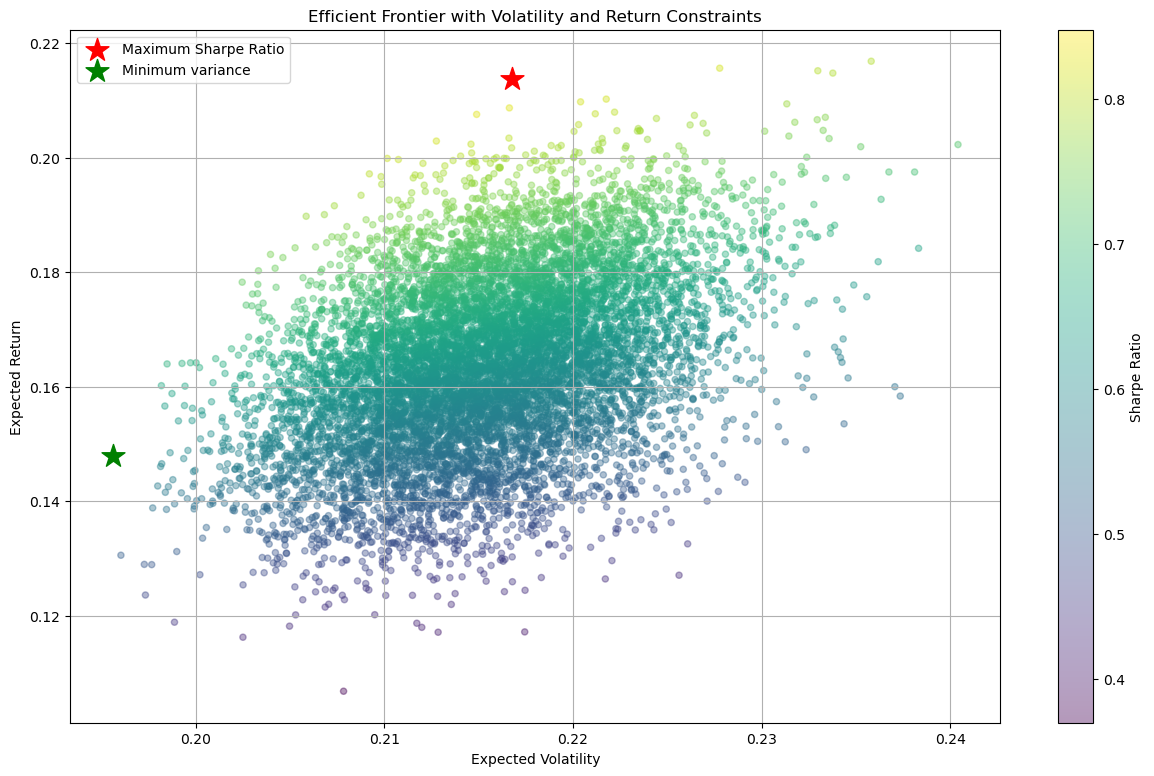

In [175]:
# Plot the efficient frontier using pandas
portfolios.plot(x='Volatility', y='Return', kind='scatter', c='Sharpe Ratio', cmap='viridis', alpha=0.4, figsize=(15, 9), colorbar=True)
plt.scatter(portfolios.loc[max_sharpe_idx,'Volatility'], portfolios.loc[max_sharpe_idx,'Return'], 
            marker='*', color='r', s=300, label='Maximum Sharpe Ratio')
plt.scatter(np.min(portfolios['Volatility']), portfolios.iloc[np.argmin(portfolios['Volatility'])]['Return'], 
            marker='*', color='g', s=300, label='Minimum variance')
plt.title('Efficient Frontier with Volatility and Return Constraints')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [176]:
# Calculate the weight allocations as percentages
max_sharpe_allocation_df = pd.DataFrame(max_sharpe_weights * 100, index=tickers, columns=['Max Sharpe Weights (%)'])
max_sharpe_allocation_df = max_sharpe_allocation_df

print(max_sharpe_allocation_df.round(5))

       Max Sharpe Weights (%)
GOOGL                 5.00000
DIS                   0.00000
VZ                    5.00000
CMCSA                 5.00000
AMZN                  5.00000
TSLA                  2.36928
HD                    1.16056
NKE                   0.00000
PG                    5.00000
KO                    5.00000
PEP                   5.00000
WMT                   5.00000
XOM                   5.00000
CVX                   0.00000
COP                   0.00000
SLB                   0.00000
JPM                   0.00000
GS                    0.00000
BAC                   0.00000
V                     0.00000
JNJ                   5.00000
PFE                   5.00000
UNH                   5.00000
ABT                   5.00000
HON                   2.44602
UNP                   5.00000
BA                    0.00000
MMM                   5.00000
AAPL                  3.28578
MSFT                  0.41291
NVDA                  0.32545
INTC                  0.00000
DOW       

In [177]:
max_sharpe_allocation_df = max_sharpe_allocation_df[max_sharpe_allocation_df['Max Sharpe Weights (%)'] > 0.01]
max_sharpe_allocation_df
print(max_sharpe_allocation_df.sum())

Max Sharpe Weights (%)    100.0
dtype: float64


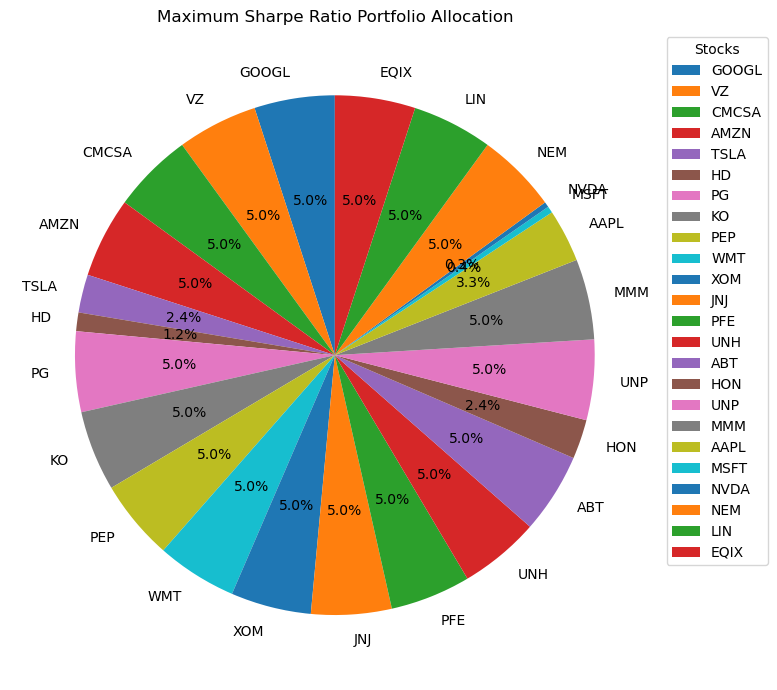

In [178]:
# Convert weights to percentages and filter out near-zero allocations
allocation_df = pd.DataFrame(max_sharpe_weights * 100, index=tickers, columns=['Allocation (%)'])
allocation_df = allocation_df[allocation_df['Allocation (%)'] > 0.01]  # Filter small allocations
allocation_df = allocation_df.round(2)

# Plot pie chart of allocations with a legend
plt.figure(figsize=(12, 7))
plt.pie(allocation_df['Allocation (%)'], labels=allocation_df.index, autopct='%1.1f%%', startangle=90)
plt.title('Maximum Sharpe Ratio Portfolio Allocation')
plt.legend(allocation_df.index, title="Stocks", bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.show()


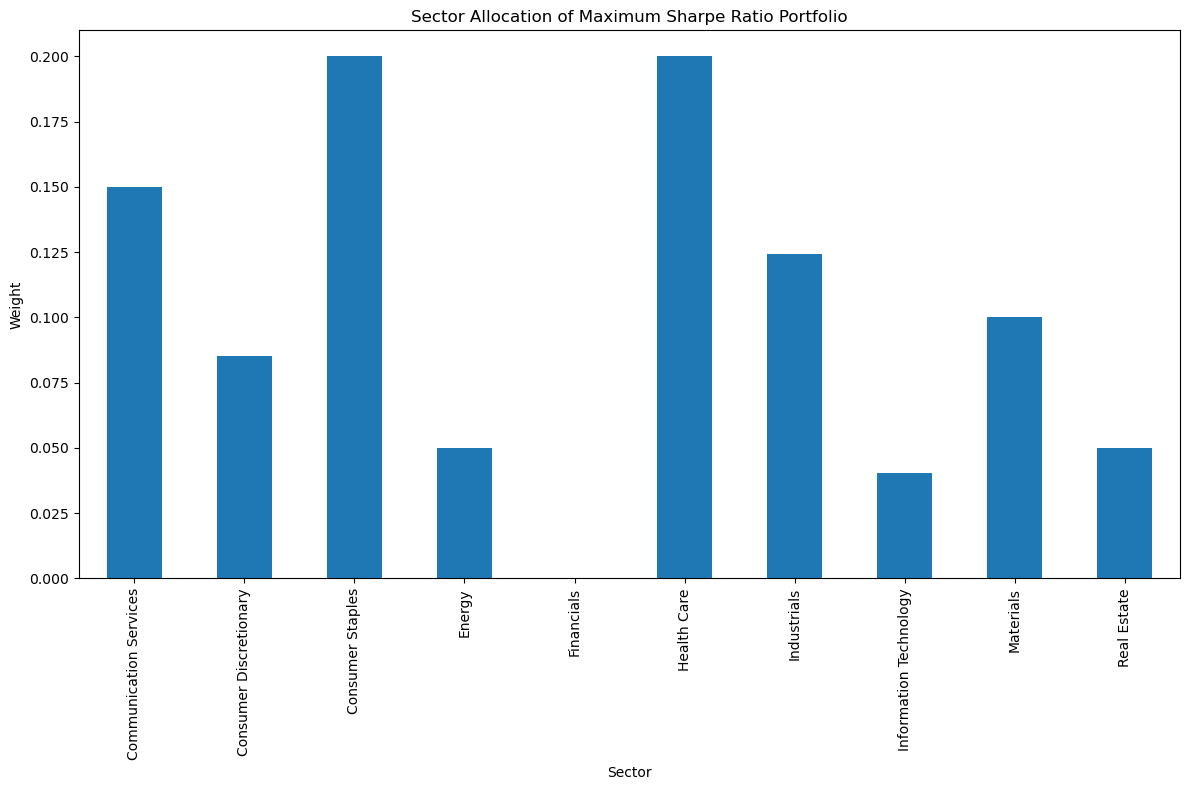

In [179]:
# Sector Allocations
sectors = {
    'GOOGL': 'Communication Services', 'DIS': 'Communication Services', 'VZ': 'Communication Services', 'CMCSA': 'Communication Services',
    'AMZN': 'Consumer Discretionary', 'TSLA': 'Consumer Discretionary', 'HD': 'Consumer Discretionary', 'NKE': 'Consumer Discretionary',
    'PG': 'Consumer Staples', 'KO': 'Consumer Staples', 'PEP': 'Consumer Staples', 'WMT': 'Consumer Staples',
    'XOM': 'Energy', 'CVX': 'Energy', 'COP': 'Energy', 'SLB': 'Energy',
    'JPM': 'Financials', 'GS': 'Financials', 'BAC': 'Financials', 'V': 'Financials',
    'JNJ': 'Health Care', 'PFE': 'Health Care', 'UNH': 'Health Care', 'ABT': 'Health Care',
    'HON': 'Industrials', 'UNP': 'Industrials', 'BA': 'Industrials', 'MMM': 'Industrials',
    'AAPL': 'Information Technology', 'MSFT': 'Information Technology', 'NVDA': 'Information Technology', 'INTC': 'Information Technology',
    'DOW': 'Materials', 'DD': 'Materials', 'NEM': 'Materials', 'LIN': 'Materials',
    'AMT': 'Real Estate', 'PLD': 'Real Estate', 'SPG': 'Real Estate', 'EQIX': 'Real Estate'
}

sector_weights = pd.Series(max_sharpe_weights, index=tickers).groupby(sectors).sum()
sector_weights.plot(kind='bar', figsize=(12, 8))
plt.title('Sector Allocation of Maximum Sharpe Ratio Portfolio')
plt.xlabel('Sector')
plt.ylabel('Weight')
plt.tight_layout()
plt.savefig('sector_allocation_max_sharpe.png')
plt.show()


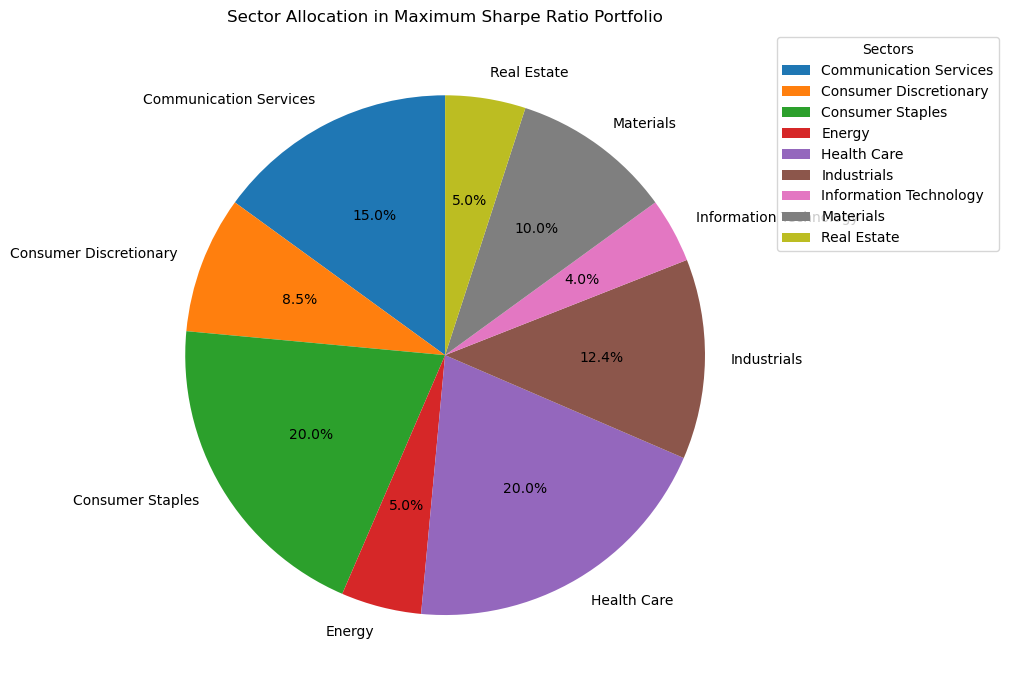

In [180]:
# Map tickers to sectors and calculate sector allocations
sector_allocation = allocation_df.groupby(sectors).sum()

# Plot pie chart of sector allocations
plt.figure(figsize=(10, 7))
plt.pie(sector_allocation['Allocation (%)'], labels=sector_allocation.index, autopct='%1.1f%%', startangle=90)
plt.title('Sector Allocation in Maximum Sharpe Ratio Portfolio')
plt.legend(sector_allocation.index, title="Sectors", bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [181]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import yfinance as yf

# Load the historical stock price data
tickers = ['GOOGL', 'DIS', 'VZ', 'CMCSA', 'AMZN', 'TSLA', 'HD', 'NKE',
           'PG', 'KO', 'PEP', 'WMT', 'XOM', 'CVX', 'COP', 'SLB',
           'JPM', 'GS', 'BAC', 'V', 'JNJ', 'PFE', 'UNH', 'ABT',
           'HON', 'UNP', 'BA', 'MMM', 'AAPL', 'MSFT', 'NVDA', 'INTC',
           'DOW', 'DD', 'NEM', 'LIN', 'AMT', 'PLD', 'SPG', 'EQIX']
data = yf.download(tickers, start='2022-07-01', end='2024-07-01')['Adj Close']

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

[*********************100%%**********************]  40 of 40 completed


In [182]:
print(len(scaled_data))


501


In [183]:
# Function to create sequences for LSTM
def create_sequences(data, time_step=120):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

# Create sequences
time_step =  120 # Use 60 days of data to predict the next day
X, y = create_sequences(scaled_data, time_step)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [184]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, X.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=X.shape[2]))  # Predicting the stock prices

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\haoyx\.dbclient\Anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [185]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.2065 - val_loss: 0.1667
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0605 - val_loss: 0.0797
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0273 - val_loss: 0.0668
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0226 - val_loss: 0.0691
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0195 - val_loss: 0.0634
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0160 - val_loss: 0.0602
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0136 - val_loss: 0.0573
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0114 - val_loss: 0.0546
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0101 - val_loss: 0.0529
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0090 - val_loss: 0.0525
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0078 - val_loss: 0.0526
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0

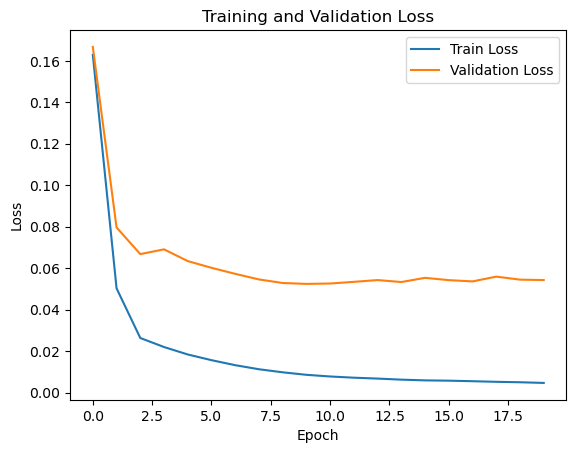

In [186]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

In [187]:
def predict_future_prices(model, data, time_step, scaler, days_ahead=30):
    predictions = []
    last_sequence = data[-time_step:]
    for _ in range(days_ahead):
        pred = model.predict(last_sequence[np.newaxis, :, :])
        predictions.append(pred.flatten())
        last_sequence = np.append(last_sequence[1:], pred, axis=0)
    predictions = scaler.inverse_transform(predictions)
    return predictions

# Predict stock prices for the next month
future_prices = predict_future_prices(model, scaled_data, time_step, scaler, days_ahead=30)

# Display the first 5 predicted prices for validation
print(future_prices[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

In [188]:
future_prices_df = pd.DataFrame(future_prices,columns=['GOOGL', 'DIS', 'VZ', 'CMCSA', 'AMZN', 'TSLA', 'HD', 'NKE',
           'PG', 'KO', 'PEP', 'WMT', 'XOM', 'CVX', 'COP', 'SLB',
           'JPM', 'GS', 'BAC', 'V', 'JNJ', 'PFE', 'UNH', 'ABT',
           'HON', 'UNP', 'BA', 'MMM', 'AAPL', 'MSFT', 'NVDA', 'INTC',
           'DOW', 'DD', 'NEM', 'LIN', 'AMT', 'PLD', 'SPG', 'EQIX'])
future_dates = pd.date_range(start='2024-07-02', periods=len(future_prices_df), freq='D')
future_prices_df.index = future_dates
print(future_prices_df)


                 GOOGL         DIS          VZ       CMCSA        AMZN  \
2024-07-02  193.082360  107.418139  162.078227  175.896432  183.636731   
2024-07-03  192.410733  107.351199  163.403291  174.555738  182.602255   
2024-07-04  191.731677  107.506559  164.824060  173.551407  182.736661   
2024-07-05  191.154141  107.730229  166.432268  172.640206  183.409783   
2024-07-06  190.650930  107.966748  168.047019  171.844971  184.341312   
2024-07-07  190.220289  108.193772  169.590788  171.215497  185.347240   
2024-07-08  189.862009  108.403547  171.032362  170.770278  186.318925   
2024-07-09  189.573917  108.597075  172.362754  170.502189  187.200509   
2024-07-10  189.350938  108.779652  173.583386  170.389182  187.969425   
2024-07-11  189.185836  108.957782  174.699631  170.402503  188.623335   
2024-07-12  189.070204  109.137415  175.718068  170.512701  189.171089   
2024-07-13  188.995176  109.323200  176.645528  170.692681  189.626651   
2024-07-14  188.952092  109.518279  17

In [189]:
# Calculate future returns based on predicted prices
fp_returns = future_prices_df.pct_change().dropna()
fp_mean_returns = fp_returns.mean() * 252
fp_cov_matrix = fp_returns.cov() * 252

In [190]:
fp_constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
    {'type': 'ineq', 'fun': volatility_constraint, 'args': (fp_cov_matrix, max_volatility)}, 
    {'type': 'ineq', 'fun': return_constraint, 'args': (fp_mean_returns, sp500_return)}
)

In [191]:
bounds = tuple((0, 0.05) for _ in range(len(tickers)))


In [192]:
initial_guess = np.array([1/len(tickers)]*len(tickers))


In [193]:
opt_results_sharpe = minimize(neg_sharpe_ratio, initial_guess, args=(fp_mean_returns, fp_cov_matrix, rf),
                              method='SLSQP', bounds=bounds, constraints=fp_constraints)
fp_max_sharpe_weights = opt_results_sharpe.x


In [194]:
num_portfolios = 10000
portfolio_returns = []
portfolio_volatilities = []
portfolio_sharpe_ratios = []

for _ in range(num_portfolios):
    weights = np.random.uniform(0, 0.05, len(tickers))
    weights /= np.sum(weights) 
    
    p_return, p_volatility = portfolio_performance(weights, fp_mean_returns, fp_cov_matrix)
    portfolio_returns.append(p_return)
    portfolio_volatilities.append(p_volatility)
    portfolio_sharpe_ratios.append((p_return - rf) / p_volatility)

In [201]:
fp_portfolios = pd.DataFrame({
    'Return': portfolio_returns,
    'Volatility': portfolio_volatilities,
    'Sharpe Ratio': portfolio_sharpe_ratios
})
print(fp_portfolios)

        Return  Volatility  Sharpe Ratio
0     0.185122    0.006816     22.758702
1     0.213294    0.007191     25.488431
2     0.267502    0.007619     31.171214
3     0.275316    0.008169     30.029394
4     0.206879    0.007565     23.379764
...        ...         ...           ...
9995  0.235650    0.005570     36.924153
9996  0.228382    0.006448     30.767401
9997  0.198184    0.005387     31.220302
9998  0.222158    0.006071     31.652134
9999  0.156624    0.006523     19.411077

[10000 rows x 3 columns]


In [207]:
fp_max_sharpe_idx = fp_portfolios['Sharpe Ratio'].idxmax()
fp_max_sharpe_idx
print(fp_portfolios.iloc[5622])

Return           0.248340
Volatility       0.004244
Sharpe Ratio    51.450659
Name: 5622, dtype: float64


In [202]:
fp_max_sharpe_idx = fp_portfolios['Sharpe Ratio'].idxmax()
fp_max_sharpe_return = fp_portfolios.loc[fp_max_sharpe_idx, 'Return']
fp_max_sharpe_volatility = fp_portfolios.loc[fp_max_sharpe_idx, 'Volatility']

In [203]:
fp_min_vol_idx = fp_portfolios['Volatility'].idxmin()
fp_min_vol_return = fp_portfolios.loc[fp_min_vol_idx, 'Return']
fp_min_vol_volatility = fp_portfolios.loc[fp_min_vol_idx, 'Volatility']



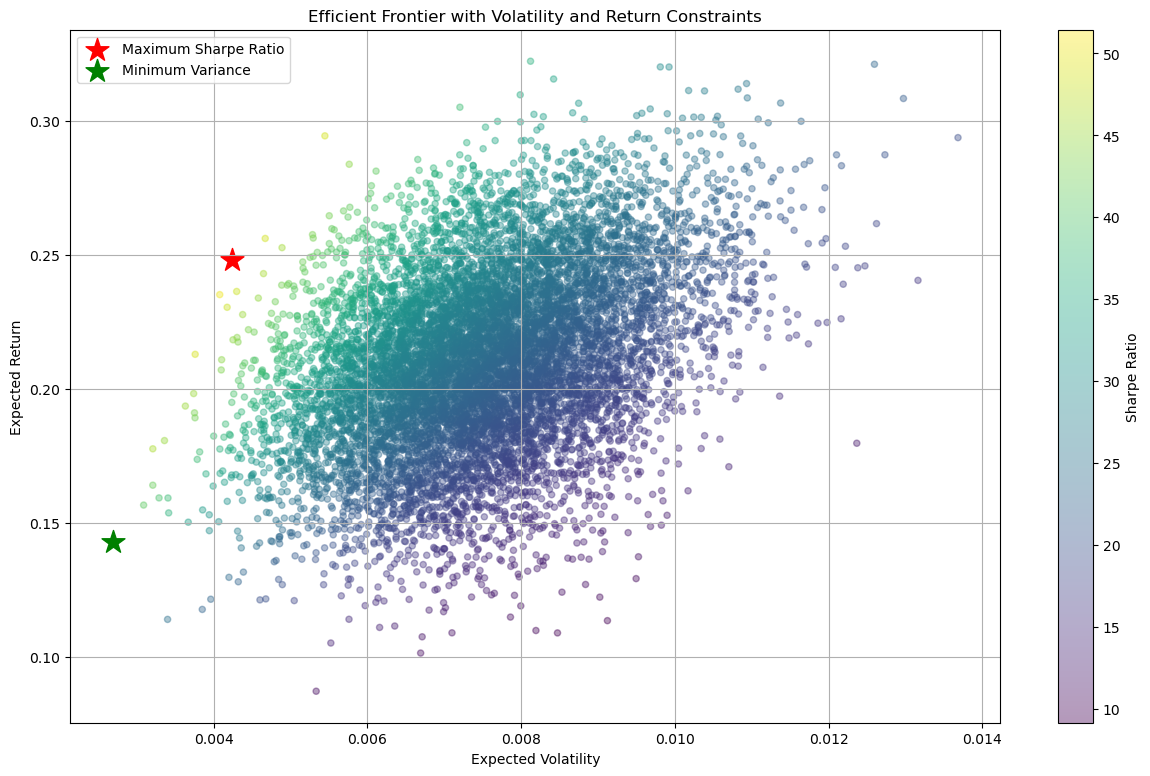

In [204]:
portfolios.plot(x='Volatility', y='Return', kind='scatter', c='Sharpe Ratio', cmap='viridis', alpha=0.4, figsize=(15, 9), colorbar=True)

plt.scatter(fp_max_sharpe_volatility, fp_max_sharpe_return, marker='*', color='r', s=300, label='Maximum Sharpe Ratio')

# 标出最小波动率组合
plt.scatter(fp_min_vol_volatility, fp_min_vol_return, marker='*', color='g', s=300, label='Minimum Variance')

plt.title('Efficient Frontier with Volatility and Return Constraints')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [205]:
print("Max Sharpe Ratio Portfolio:")
print(portfolios.loc[max_sharpe_idx])

print("Min Volatility Portfolio:")
print(portfolios.loc[min_vol_idx])


Max Sharpe Ratio Portfolio:
Return           0.248340
Volatility       0.004244
Sharpe Ratio    51.450659
Name: 5622, dtype: float64
Min Volatility Portfolio:
Return           0.143001
Volatility       0.002685
Sharpe Ratio    42.084669
Name: 5780, dtype: float64


In [198]:
fp_max_sharpe_allocation_df = pd.DataFrame(fp_max_sharpe_weights * 100, index=tickers, columns=['Max Sharpe Weights (%)'])
print("FP Max Sharpe Ratio Portfolio Allocation:")
print(fp_max_sharpe_allocation_df.round(2))

FP Max Sharpe Ratio Portfolio Allocation:
       Max Sharpe Weights (%)
GOOGL                    0.05
DIS                      4.11
VZ                       4.91
CMCSA                    3.05
AMZN                     0.00
TSLA                     4.94
HD                       0.03
NKE                      4.97
PG                       5.00
KO                       5.00
PEP                      4.97
WMT                      4.97
XOM                      0.03
CVX                      0.00
COP                      0.00
SLB                      4.91
JPM                      4.98
GS                       0.01
BAC                      4.99
V                        2.59
JNJ                      0.03
PFE                      4.97
UNH                      2.75
ABT                      0.03
HON                      0.03
UNP                      0.00
BA                       0.00
MMM                      2.14
AAPL                     5.00
MSFT                     4.97
NVDA                     0.0

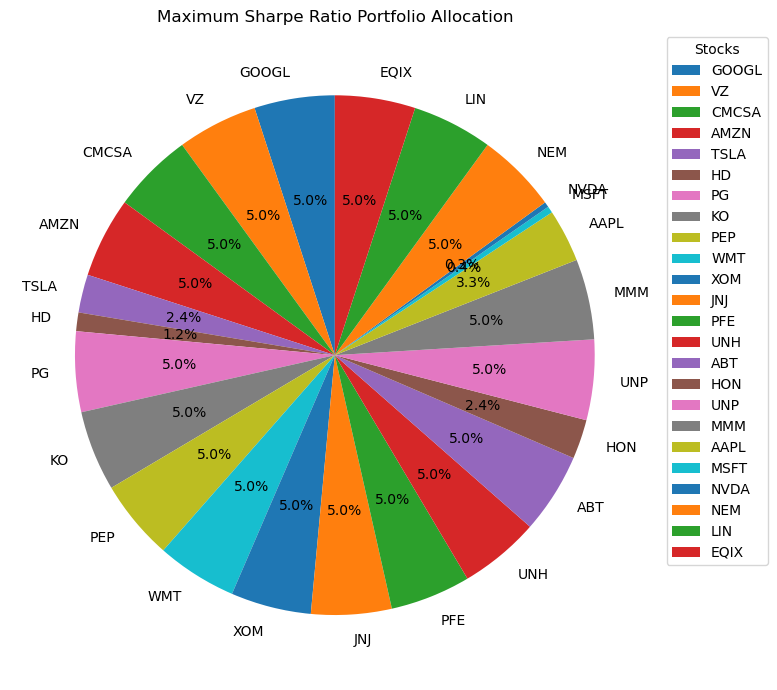

In [199]:
allocation_df = pd.DataFrame(max_sharpe_weights * 100, index=tickers, columns=['Allocation (%)'])
allocation_df = allocation_df[allocation_df['Allocation (%)'] > 0.01]  # Filter small allocations
allocation_df = allocation_df.round(2)

# Plot pie chart of allocations with a legend
plt.figure(figsize=(12, 7))
plt.pie(allocation_df['Allocation (%)'], labels=allocation_df.index, autopct='%1.1f%%', startangle=90)
plt.title('Maximum Sharpe Ratio Portfolio Allocation')
plt.legend(allocation_df.index, title="Stocks", bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.show()

       Difference (%)
GOOGL           -4.95
VZ              -0.09
CMCSA           -1.95
AMZN            -5.00
TSLA             2.57
HD              -1.13
PG              -0.00
KO              -0.00
PEP             -0.03
WMT             -0.03
XOM             -4.97
JNJ             -4.97
PFE             -0.03
UNH             -2.25
ABT             -4.97
HON             -2.41
UNP             -5.00
MMM             -2.86
AAPL             1.71
MSFT             4.56
NVDA            -0.30
NEM             -4.99
LIN             -4.80
EQIX            -0.01


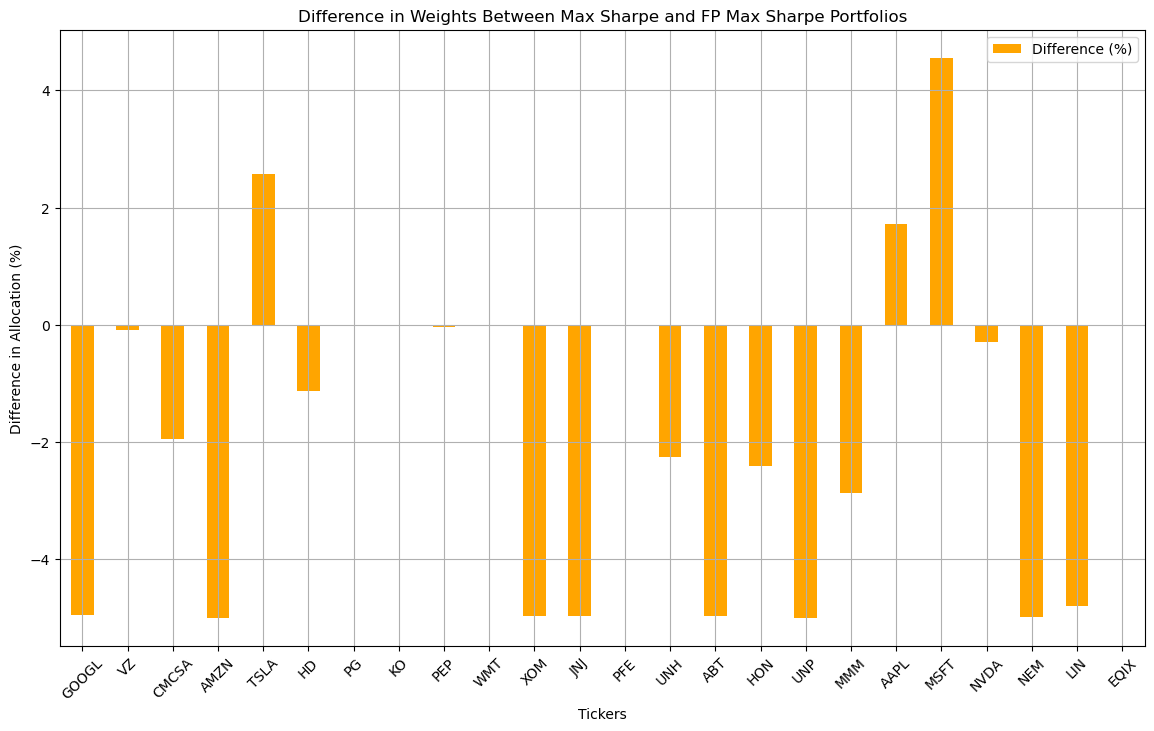

In [200]:
fp_max_sharpe_allocation_df = fp_max_sharpe_allocation_df.reindex(index=max_sharpe_allocation_df.index)

fp_max_sharpe_allocation_df.fillna(0, inplace=True)
max_sharpe_allocation_df.fillna(0, inplace=True)

difference_df = fp_max_sharpe_allocation_df - max_sharpe_allocation_df
difference_df.columns = ['Difference (%)']

print(difference_df.round(2))

difference_df.plot(kind='bar', figsize=(14, 8), color='orange')
plt.title('Difference in Weights Between Max Sharpe and FP Max Sharpe Portfolios')
plt.xlabel('Tickers')
plt.ylabel('Difference in Allocation (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
